In [ ]:
%matplotlib inline
#魔法命令，通常在Jupyter Notebook中使用，将matplotlib图形嵌入到notebook的输出单元中，而不需要额外调用show()来显示图形
import matplotlib.pyplot as plt
import random
import torch
from d2l import torch as d2l

In [ ]:
import torch

def synthetic_data(w, b, num_examples):
    """生成y = Xw + b + 噪声"""
    x = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(x, w) + b
    y += torch.normal(0, 0.01, y.shape)  # 这里修正了 y+ 变成 y+=
    return x, y.reshape((-1, 1))  # 用 reshape(-1,1)确保元素总数不变下改变数组维度，-1表示自动推测行数

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)


In [2]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([-0.4965, -1.4841]) 
label: tensor([8.2459])


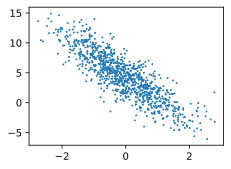

In [7]:
d2l.set_figsize()
d2l.plt.scatter(features[:,1].detach().numpy(),labels.detach().numpy(),1)
#detach()函数的作用是返回一个新的Variable，从当前计算图中分离下来的，但是仍指向原变量的存放位置,不同之处在于新的Variable是volatile的，即不会求导


In [ ]:
#定义一个data_iter函数，接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量
def data_iter(batch_size,features,labels):
    num_examples=len(features)
    indices=list(range(num_examples))
    #这些样本是随机读取的，没有特定顺序
    random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
        batch_indices=torch.tensor(
            indices[i:min(i+batch_size,num_examples)])
        yield features[batch_indices],labels[batch_indices]
#yield生成迭代器，支持惰性计算，节省内存，适用于处理流式数据
batch_size=10
for X,y in data_iter(batch_size,features,labels):
    print(X,'\n',y)
    break
#for循环作用于返回可迭代对象(列表、元组、字符串、字典、集合等)的函数，相当于直接遍历其返回值


tensor([[ 0.4801, -0.9760],
        [-0.3886, -0.6756],
        [-1.5019, -0.1404],
        [-0.6742, -1.2923],
        [ 0.3105,  1.2475],
        [-0.4353, -0.5143],
        [-0.4328, -0.6102],
        [-0.5567,  0.4641],
        [-0.8264,  0.3547],
        [-1.0067, -0.1893]]) 
 tensor([[8.4842],
        [5.7155],
        [1.6581],
        [7.2352],
        [0.5855],
        [5.0703],
        [5.4188],
        [1.4841],
        [1.3528],
        [2.8335]])


In [9]:
#定义初始化模型参数
w=torch.normal(0,0.01,size=(2,1),requires_grad=True)
b=torch.zeros(1,requires_grad=True)
#定义模型
def linreg(X,w,b):
    """线性回归模型"""
    return torch.matmul(X,w)+b

In [17]:
#定义损失函数
def squared_loss(y_hat,y):
    """均方误差"""
    return (y_hat-y.reshape(y_hat.shape))**2/2
#定义优化算法
def sgd(params,lr,batch_size):#lr是学习率
    with torch.no_grad():
        for param in params:
            param-=lr*param.grad/batch_size #均值
            param.grad.zero_()#手动将梯度设为0

In [18]:
#训练过程
#超参数定义
lr=0.03
num_epochs=3
net=linreg
#模型选择
loss=squared_loss
for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        l=loss(net(X,w,b),y)#小批量损失
        #此处l形状为(batch_size,1)
        l.sum().backward()
        sgd([w,b],lr,batch_size)
    with torch.no_grad():
        train_l=loss(net(features,w,b),labels)
        print(f'epoch{epoch+1},loss{float(train_l.mean()):f}')

epoch1,loss0.000052
epoch2,loss0.000052
epoch3,loss0.000052


In [20]:
print(f'w的估计误差:{true_w-w.reshape(true_w.shape)}')
print(f'b的估计误差:{true_b-b}')

w的估计误差:tensor([0.0002, 0.0001], grad_fn=<SubBackward0>)
b的估计误差:tensor([0.0009], grad_fn=<RsubBackward1>)


In [ ]:
#简洁实现
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

In [ ]:
#生成数据集
true_w=torch.tensor([2,-3.4])
true_b=4.2
features,labels=d2l.synthetic_data(true_w,true_b,1000)

In [24]:
#读取数据集
def load_array(data_arrays,batch_size,is_train=True):#@save
    """构造一个pytorch数据迭代器"""
    dataset=data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset,batch_size,shuffle=is_train)
batch_size=10
data_iter=load_array((features,labels),batch_size)
next(iter(data_iter))

[tensor([[ 1.3243, -1.1068],
         [-2.1964,  2.3040],
         [ 0.4625,  1.0909],
         [-0.7558, -2.5021],
         [ 0.6159,  0.3671],
         [-0.2412, -0.3398],
         [-0.6879, -0.2693],
         [ 3.0377, -0.5956],
         [-0.5423,  1.4934],
         [ 0.7589,  0.2787]]),
 tensor([[10.6257],
         [-8.0124],
         [ 1.4082],
         [11.2012],
         [ 4.1955],
         [ 4.8647],
         [ 3.7510],
         [12.3036],
         [-1.9762],
         [ 4.7718]])]

In [25]:
#定义模型
from torch import nn
net=nn.Sequential(nn.Linear(2,1))

In [ ]:
#初始化模型参数
net[0].weight.data.normal_(0,0.01)#权重
net[0].bias.data.fill_(0)#偏置

tensor([0.])

In [ ]:
#计算均方误差使用MSELoss类，也成为平方L2范数
loss=nn.MSELoss()

In [ ]:
trainer=torch.optim.SGD(net.parameters(),lr=0.03)

In [ ]:
#训练
num_epochs=3
for epoch in range(num_epochs):
    for X,y in data_iter:
        l=loss(net(X),y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l=loss(net(features),labels)
    print(f"epoch{epoch+1},loss{l:f}")

eposh1,loss0.000241
eposh2,loss0.000098
eposh3,loss0.000098
